<a href="https://colab.research.google.com/github/AudePertron/AI_days_emotions/blob/main/Tuto_Emotions_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconnaissance des Emotions - 1/2

## - Exploration des données et création des Datasets, 

## - Entraînement du modèle d'identification des émotions

<hr>

- <a href='#1'>Prévisualisation des données</a>
- <a href='#2'>Création des datasets d'apprentissage et de test</a>
- <a href='#3'>Préparation des données</a>
- <a href='#4'>Entrainement du modèle de reconnaissance des émotions</a>
- <a href='#5'>Résultats</a> 

<hr>

In [1]:
#préparation des imports (bibliothèques et librairies nécéssaires à l'éxécution du code)
import os
import sys
import numpy as np
import cv2
import pickle
import random

from glob import glob

from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from keras.layers import Conv2D, experimental, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
tf.random.set_seed(8449744397167270535)
random.seed(8449744397167270535)

### <a id='1'>Prévisualisation des données</a>

>Si vous souhaitez exécuter ce notebook sur Google Colab (ce que nous vous conseillons), l'exécution des cellules suivantes vous permettra de cloner directement le repository GitHub, et d'extraire le ficher `.zip` de la data. N'oubliez pas d'activer l'option GPU de Colab : `Runtime/Change Runtime type` si vous utlisez Colab en anglais, ou `Execution/Modifier le type d'exécution` pour la version française, puis choisissez "GPU".

>Vous pouvez bien sûr choisir d'exécuter les notebooks en local sur votre ordinateur, particulièrement si vous possédez un GPU. __Dans ce cas, il est inutile d'executer les 3 cellules suivantes.__

In [2]:
!git clone https://github.com/AudePertron/AI_days_emotions.git

Cloning into 'AI_days_emotions'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 182 (delta 80), reused 27 (delta 9), pack-reused 0
Receiving objects: 100% (182/182), 36.58 MiB | 30.28 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [3]:
!unzip /content/AI_days_emotions/data/emotions.zip -d /content/AI_days_emotions/data &> /dev/null
print("Extraction des données terminée")

Extraction des données terminée


In [10]:
%cd AI_days_emotions/

/content/AI_days_emotions


Notre dossier Data contient l'ensemble des données, séparées en données d'entraînement et données de test, elles-mêmes divisées en sous-dossiers par émotions. Vous pouvez visualiser l'arborescence des dossiers grâce à l'icône "Files" à gauche de votre écran, dans le menu Colab.

Chaque sous-dossier d'émotions contient des images en noir et blanc de 48*48 pixel.
Nous allons commencer par créer nos datasets d'entrainement et de test, qui contiendront les données des images et leur label. Nous allons, dans ce temps qui précède l'entraînement du modèle :
- récupérer la liste des labels (type d'émotion exprimé)
- récupérer chaque image et son label, et la placer soit dnas le dataset d'entrainement, soit dans le dataset de test.
- mélanger (randomisation) les images.
- préparer les données, notamment :
    - en normalisant les valeurs des pixels des images,
    - en encodant les labels.
- visualiser un extrait de notre dataset.

In [11]:
#Nous accédons aux données depuis le dossier dans lequel elles sont stockées
tmp = os.listdir("./data/train") 

print("La liste 'tmp' contient les noms de chacun des dossiers. Les voici :")
print(" -", "\n - ".join(tmp))

#On prépare les labels (noms des émotions) en les récupérant à partir des noms de dossier.
#On prépare d'abord un dictionnaire qui contiendra les numéros et les noms des classes 
#en fonction des noms des dossiers.
LABELS ={} 
for clas, feeling in enumerate(tmp): # on itère sur la liste tmp pour récupérer ces labels.
    LABELS[clas]=feeling

NUM_CLASS = len(tmp) # le nombre de classes correspond au nombre de dossiers

print("\nIl y a donc", NUM_CLASS, "classes :")
print(LABELS)

La liste 'tmp' contient les noms de chacun des dossiers. Les voici :
 - sad
 - surprise
 - happy
 - angry

Il y a donc 4 classes :
{0: 'sad', 1: 'surprise', 2: 'happy', 3: 'angry'}


In [12]:
#nous indiquons l'emplacement des images, et créons une liste d'entraînement et une liste de test vides

trainset = []
for i in tmp: # on itère sur tmp pour parcourir chacun des 4 dossiers
    chemin = "./data/train/"+i
    img = glob("%s/*.jpg" %chemin) # la fonction glob permet de récupérer tous les fichiers d'un dossier
    img = [os.path.abspath(x) for x in img]
    trainset.append(img)

testset = []
for i in tmp:
    chemin = "./data/test/"+i
    img = glob("%s/*.jpg" %chemin)
    img = [os.path.abspath(x) for x in img]
    testset.append(img)

#Nous affichons le nombre d'images par catégorie :
print("Nombre d'images de chaque classe dans le train set :")
print([(LABELS[i], len(trainset[i])) for i in range(len(trainset))])
print("Et dans le test set :")
print([(LABELS[i], len(testset[i])) for i in range(len(testset))])

Nombre d'images de chaque classe dans le train set :
[('sad', 4830), ('surprise', 3171), ('happy', 7215), ('angry', 3995)]
Et dans le test set :
[('sad', 1247), ('surprise', 831), ('happy', 1774), ('angry', 958)]


### <a id='2'>Création des datasets d'apprentissage et de test</a>

Nous créons les données d'entraînement. 


Notre objectif, plus communément appelé "target" et abrégé en "y" est le nom de l'émotion associée à chaque image, qu'on appellera "label". Il s'agit d'associer chaque y au X correspondant. Donc par exemple si `X[0]` correspond à une image d'une personne heureuse, `y[0]` sera égal à la variable "happy" (les noms de variables sont ici représentés par des chiffres, comme vu ci-dessus)


In [13]:
# Nous créons la liste y_train (target sur les données d'entraînement)
paths=[]
y_train=[]

for i in range(len(trainset)):
    for j in range(len(trainset[i])):
        paths.append(trainset[i][j])
        y_train.append(i)

Les données que nous devons analyser, appelées "features" et abrègées en "X", sont les images. Chaque image est représenté par une matrice de taille 48x48 (hauteur * largeur de l'image en pixel), dont les chaque valeur peut varier entre 0 et 255 suivant la valeur du pixel en niveaux de gris (0 représentant le noir et 255 le blanc). Dans le cas d'images de couleur, il y aurait trois matrices (appelées canaux) pour chacune des valeurs RGB (rouge, vert, bleu).

Pour charger ces images sous forme de matrices d'entiers entre 0 et 255, nous utilisons le module `imread` de la bibliothèque `OpenCV` (`cv2`).

In [14]:
X_train=[]
for p in paths:
    X_train.append(cv2.imread(p, 0))

Préparons ensuite des données de test, de la même façon que les données d'entraînement. Ces données nous serviront à la fin de cet exercice à évaluer notre modèle, c'est à dire à vérifier que notre modèle fonctionne bien sur de nouvelles images, sur lesquelles il n'a pas été entrainé, et donc qu'il ne "connaît" pas.

In [15]:
paths2=[]
y_test=[]

for i in range(len(testset)):
    for j in range(len(testset[i])):
        paths2.append(testset[i][j])
        y_test.append(i)

In [16]:
X_test=[]
for p in paths2:
    X_test.append(cv2.imread(p, 0))

### <a id='3'>Préparation des données</a>

#### Chargement des données

Nous allons maintenant visualiser une image du dataset ainsi que son label pour vérifier que tout fonctionne correctement. Nous affichons de façon arbitraire l'image numéro 42, n'hésitez pas à modifier cette variable si vous souhaitez visualiser d'autres images du dataset.
Nous en profitons pour afficher la dimension de l'image. La longueur de X_train indique le nombre d'images contenu dans le dataset.

Il y a 19211 images de (48, 48) pixels dans le dataset. 
Voici par exemple l'image n°42 :


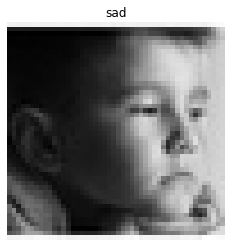

In [17]:
plt.imshow(X_train[42], cmap="gray")
plt.axis("off")
print(f"Il y a {len(X_train)} images de {X_train[42].shape} pixels dans le dataset.\
 \nVoici par exemple l'image n°42 :")
plt.title(LABELS[y_train[42]])
plt.show()

#### Mélange des données

Nous allons maintenant mélanger les données (comme si l'on mélangeait des cartes avant une partie) car elles sont pour l'instant classées dans l'ordre des émotions.

In [18]:
# pour l'entraînement
# on crée un vecteur de nombres de allant de 0 à 1921 triés aléatoirement 
index = np.random.permutation([i for i in range(len(y_train))]) 
# on classe X_train et y_train suivant cet ordre aléatoire.
X_train = np.asarray(X_train)[index] 
y_train = np.asarray(y_train)[index]
print(X_train.shape)
print(y_train.shape)

(19211, 48, 48)
(19211,)


In [19]:
# pour les tests
index2 = np.random.permutation([i for i in range(len(y_test))])

X_test = np.asarray(X_test)[index2]
y_test = np.asarray(y_test)[index2]
print(X_test.shape)
print(y_test.shape)

(4810, 48, 48)
(4810,)


Visualisons maintenant quelques-une de ces images, par exemple les 15 premières, en affichant le label, afin de vérifier notre dataset avant de commencer l'entraînement.

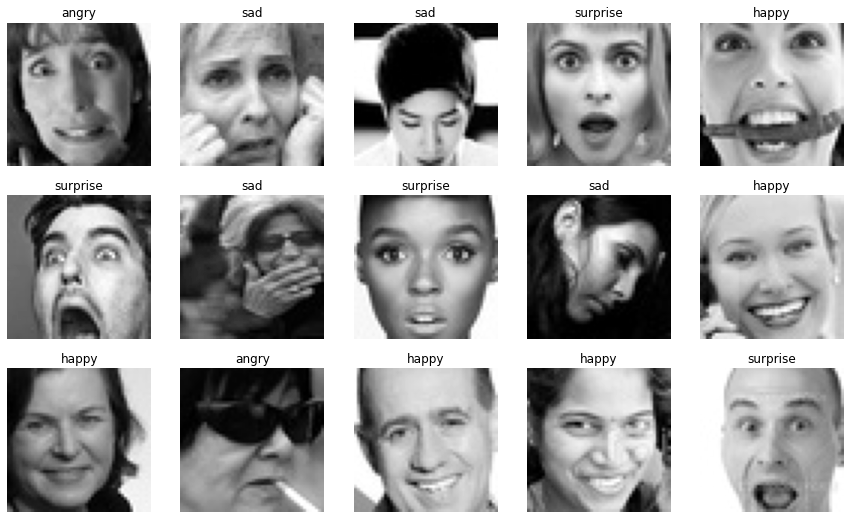

In [20]:
# visualisation
plt.figure(figsize=(15,9))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(np.uint8(X_train[i]), cmap='gray')
    plt.title(LABELS[y_train[i]])
    plt.axis('off')
plt.show()

#### Prétraitement en vue de l'entrainement avec un CNN Séquentiel 

Il s'agit de transformer les données dans le format attendu par l'algorithme. 

Il faut d'abord normaliser les données, c'est à dire transformer toutes les valeurs de pixels afin qu'elles soient comprises entre 0 et 1. Comme la valeur maximale d'un pixel est de 255, il suffit de diviser les valeurs par ce nombre. 

Puis nous donnons la "forme" attendue à notre matrice. Nous précisons le nombre de canaux de nos images : "1" pour une image en noir et blanc ("3", correspondant aux canaux rouge, vert,  bleu, pour une image en couleur).

In [21]:
# standardisation, redimensionnement des features
X_train = X_train.astype('float') / 255
X_test = X_test.astype('float') / 255
X_train = X_train.reshape(len(X_train),48,48,1)
X_test = X_test.reshape(len(X_test),48,48,1)

Nous encodons également nos valeurs-cibles (targets) y. Plutôt qu'avoir des valeurs entre 0 et 4 correspondant à un numéro arbitraire, nous le transformons en une liste de 0 et de 1, le 1 correspondant à l'émotion représentée.

Par exemple, dans le cas de la joie, qui était auparavant égale à 3, nous aurons :
- avant : `y=1`
- après : `Y=[0,1,0,0]`

ou pour la tristesse:
- avant : `y=3`
- après : `Y=[0,0,1,0]`
et ainsi de suite.

Cela permet d'éviter des biais car l'algorihtme pourrait accorder une plus grande importance à une émotion dont la valeur est plus élevée (considérer qu'une émotion avec pour valeur 4 est plus importante qu'une émotion avec une valeur 0).

In [22]:
# catégorisation des target
y_test.reshape(len(y_test),1)
y_train.reshape(len(y_train),1)
Y_train = to_categorical(y_train, num_classes=NUM_CLASS).astype(int)
Y_test = to_categorical(y_test, num_classes=NUM_CLASS).astype(int)

In [23]:
# vérificationpour un élément au hasard du set d'entrainement
print(Y_train[42], y_train[42], LABELS[y_train[42]]) 

[1 0 0 0] 0 sad


In [24]:
# vérificationpour un élément au hasard du set de test
print(Y_test[42], y_test[42], LABELS[y_test[42]]) #test

[0 0 1 0] 2 happy


### <a id='4'>Entrainement du modèle de reconnaissance des émotions</a>

#### Création du modèle séquentiel

Nous allons maintenant appliquer un réseau de neurones convolutif sur nos données. Le temps d'entraînement peut être long, aussi, __pour gagner du temps, nous vous proposons de télécharger notre modèle préentraîné par la suite__, mais à nouveau, si en vous avez le temps, vous êtes libres d'éxécuter le modèle tel quel, voir même de jouer avec les paramètres pour le modifier !

Ce modèle est composé de 15 couches de neurones. En modifiant ses paramètres vous pourriez obtenir des résultats très différents (peut-être meilleurs que les nôtres !).

<br>

Il vous faudra environ 10 à 15 minutes minutes pour entraîner le modèle proposé. Pendant ce temps, n'hésitez pas à nous poser vos questions ! 

In [ ]:
### nous avons construit le modèle suivant, c'est celui qui sera fourni pour la suite de l'exercice
### Libre à vous de le modifier et de créer votre propre modèle !

modelX = models.Sequential()

modelX.add(Conv2D(64, 7, padding="same", activation='relu', input_shape=(48,48,1)))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(64, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Conv2D(128, 3, padding="same", activation='relu'))
modelX.add(MaxPooling2D(2))
modelX.add(Dropout(0.5))
modelX.add(Flatten())
modelX.add(Dense(64, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(32, activation="relu"))
modelX.add(Dropout(0.25))
modelX.add(Dense(NUM_CLASS, activation='softmax'))

In [ ]:
# compilation pour un premier entraînement avec l'optimizer Adamax
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
### décommentez la ligne suivante si vous voulez entraîner votre propre modèle

history = modelX.fit(X_train, Y_train, epochs=40, batch_size=5, validation_split=0.2)

Au bout de nos 40 epochs, bien que le modèle semble converger, l'accuracy ne s'est pas tout à fait stabilisée. Cet indicateur nous informe sur la précision du modèle à faire de bonnes prédictions, plus on s'approche de 1, plus le modèle est performant. A chaque Epoch (itération), le modèle va (logiquement) parfaire son entrainement.

Il semble que l'on puisse améliorer un peu ce résultat. Relançons l'entraînement pour 10 epoch, en affinant les hyperparamètres de l'optimizer Adamax.

In [ ]:
# second entrainement en affinant les parametres 
modelX.compile(optimizer=optimizers.Adamax(learning_rate=0.0001, beta_1=0.98, beta_2=0.98), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
### décommentez la ligne suivante si vous voulez entraîner votre propre modèle

history = modelX.fit(X_train, Y_train, epochs=10, batch_size=5, validation_split=0.2)

In [ ]:
### exectutez la ligne suivante si vous souhaitez enregistrer votre modèle personnalisé.

modelX.save('My_model')

Grâce au deuxième entrainement, nous parvenons à un score stable autour de  72%. Dans l'absolu, ce score peut ne pas paraître excellent, mais par rapport aux données utilisées c'est un score honorable.

Vous pouvez essayer de relancer ce modèle (nous vous conseillons de le faire sur Colab ou avec un GPU) en jouant sur l'optimizer et ses hyperparamètre, ou même en modifiant le nombre de couches et de neurones par couches dans le modèle, vous obtiendrez peut-être un meilleur score que nous !

#### Validation sur la base de données de test

Nous allons mainteant évaluer nos résulats grâce à nos données de test. Dans la cellule suivante, nous vous proposons de charger notre modèle pré-entrainé, si vous n'avez pas exécuté les lignes précédentes. 

Vous pouvez également charger le modèle que vous venez d'enregistrer, soit avec les paramètres que nous avons proposé soit avec vos propres paramètres. 

Décommentez la ligne qui concerne le chargement que vous voulez effectuer (ou bien continuez avec le modèle que vous venez d'entraîner).

In [ ]:

#### Pour charger le modèle pré-entrainé :
# modelX = models.load_model('ModelX') 

#### OU 
#### Pour charger le modèle que vous venez d'enregistrer :
modelX = models.load_model('My_model') 

In [ ]:
len(X_test)
X_test.shape

Nous examinons les prédictions de notre algorithme sur les données de test, et les comparons à leur valeur réelle.

In [ ]:
Y_pred = modelX.predict(X_test) # on demande à notre modèle de réaliser les prédictions sur la base de test.

In [ ]:
y_pred=[]
for y in Y_pred:
    y_pred.append(np.argmax(y))
# on décode les prédictions, afin de passer du format Y=[0,0,1,0] au format y=2, à l'inverse ce qu'on a fait plus haut. 

L'utilisation d'une matrice de confusion nous montrera _où_ l'algorithme se "trompe". 

Dans l'idéal, toutes les valeurs devraient être sur la diagonale haut-gauche / bas-droite. Les valeurs qui se situent sur cette diagonale sont les images correctement identifiées. 
Les autres sont mal identifiées : les valeurs réelles se situent sur l'axe des ordonnées, et les valeurs prédites sur les abscisses.

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred) 
# le module metrics.confusion_matrix est disponible dans la bibliothèque scikit-learn

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(cf_matrix, cmap="Purples")
for (i, j), z in np.ndenumerate(cf_matrix):
    plt.text(j, i, z, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.xlabel("valeurs prédites")
plt.xticks(ticks =[i for i in range(4)], labels=[LABELS[i] for i in range(4)])
plt.ylabel("valeurs réelles")
plt.yticks(ticks =[i for i in range(4)], labels=[LABELS[i] for i in range(4)])
plt.show()

### <a id='5'>Résultats</a>

La matrice de confusion nous montre que le modèle semble avoir plus de mal à reconnaître certains sentiments que d'autres. 

Si l'on regarde les images de la colère, par exemple : un peu plus de la moitié d'entre elles ont dû être correctement identifiées, mais presque toutes les autres ont probablement été prises pour des expressions de la tristesse. Il y a d'ailleurs aussi beaucoup de mauvaises interprétations du sentiment de tristesse. 

Pas terrible... Qu'en pensez-vous ? 
Maintenant, allez regarder les images du dataset : à l'oeil nu, auriez-vous pu faire mieux ? ;)

Car en effet, une bonne part de la réussite d'un modèle d'intelligence artificielle réside dans la collecte et la préparation des données. La recherche des paramètres optimaux (nombre de couches de convolution, optimisateur utilisé, taux d'apprentissage, fonction de perte, etc.) ne fait pas tout. Il faut d'abord réunir un dataset cohérent, correctement labellisé et préparé, avant d'entreprendre toute tâche de machine-learning ou de deep_learning.